In [3]:
import atlite
import xarray as xr
import pandas as pd
import scipy.sparse as sp
import numpy as np

import pgeocode
from collections import OrderedDict

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [12]:
import requests
import os
import zipfile

In [13]:
def download_file(url, local_filename):
    # variant of http://stackoverflow.com/a/16696317
    if not os.path.exists(local_filename):
        r = requests.get(url, stream=True)
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    return local_filename

In [14]:
# Dowloading the wind speed and solar radiation
opsd_fn = download_file("https://data.open-power-system-data.org/index.php?package=time_series&version=2019-06-05&action=customDownload&resource=3&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bfrom%5D=2012-01-01&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bto%5D=2013-05-01&filter%5BRegion%5D%5B%5D=DE&filter%5BVariable%5D%5B%5D=solar_generation_actual&filter%5BVariable%5D%5B%5D=wind_generation_actual&downloadCSV=Download+CSV",
    "time_series_60min_singleindex_filtered.csv",)

In [29]:
pd.read_csv(opsd_fn)

,utc_timestamp,cet_cest_timestamp,DE_solar_generation_actual,DE_wind_generation_actual
0,2011-12-31T23:00:00Z,2012-01-01T00:00:00+0100,NaN,4576
1,2012-01-01T00:00:00Z,2012-01-01T01:00:00+0100,NaN,4871
2,2012-01-01T01:00:00Z,2012-01-01T02:00:00+0100,NaN,5409
3,2012-01-01T02:00:00Z,2012-01-01T03:00:00+0100,NaN,6094
4,2012-01-01T03:00:00Z,2012-01-01T04:00:00+0100,NaN,6734
...,...,...,...,...
11682,2013-05-01T17:00:00Z,2013-05-01T19:00:00+0200,1688.0,2307
11683,2013-05-01T18:00:00Z,2013-05-01T20:00:00+0200,223.0,2526
11684,2013-05-01T19:00:00Z,2013-05-01T21:00:00+0200,0.0,2975
11685,2013-05-01T20:00:00Z,2013-05-01T22:00:00+0200,0.0,3054


In [31]:
# removing the time zone information
opsd = pd.read_csv(opsd_fn, parse_dates=True, index_col=0)
opsd.index = opsd.index.tz_convert(None)
opsd = opsd[("2011" < opsd.index) & (opsd.index < "2013")]

In [35]:
print(opsd)

                           cet_cest_timestamp  DE_solar_generation_actual  \
utc_timestamp                                                               
2011-12-31 23:00:00  2012-01-01T00:00:00+0100                         NaN   
2012-01-01 00:00:00  2012-01-01T01:00:00+0100                         NaN   
2012-01-01 01:00:00  2012-01-01T02:00:00+0100                         NaN   
2012-01-01 02:00:00  2012-01-01T03:00:00+0100                         NaN   
2012-01-01 03:00:00  2012-01-01T04:00:00+0100                         NaN   
...                                       ...                         ...   
2012-12-31 19:00:00  2012-12-31T20:00:00+0100                         0.0   
2012-12-31 20:00:00  2012-12-31T21:00:00+0100                         0.0   
2012-12-31 21:00:00  2012-12-31T22:00:00+0100                         0.0   
2012-12-31 22:00:00  2012-12-31T23:00:00+0100                         0.0   
2012-12-31 23:00:00  2013-01-01T00:00:00+0100                         0.0   

In [ ]:
# Downloading the installed PV capacities in Germany
eeg_fn =  download_file("http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip",
    "eeg_anlagenregister_2015.08.utf8.csv.zip",)

In [37]:
with zipfile.ZipFile(eeg_fn, "r") as zip_ref:
    zip_ref.extract("eeg_anlagenregister_2015.08.utf8.csv")

In [40]:
import geopandas as gpd
import cartopy.io.shapereader as shpreader

In [48]:
shp = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
)


In [86]:
iso_a2_codes = [record.attributes["ISO_A2"] for record in shp.records()]
print(iso_a2_codes)

['ID', 'MY', 'CL', 'BO', 'PE', 'AR', '-99', 'CY', 'IN', 'CN', 'IL', 'PS', 'LB', 'ET', 'SS', 'SO', 'KE', 'MW', 'TZ', 'SY', '-99', '-99', 'SR', 'GY', 'KR', 'KP', 'MA', 'EH', 'CR', 'NI', 'CG', 'CD', 'BT', 'UA', 'BY', 'NA', 'ZA', 'MF', 'SX', 'OM', 'UZ', 'KZ', 'TJ', 'LT', 'BR', 'UY', 'MN', 'RU', 'CZ', 'DE', 'EE', 'LV', '-99', 'SE', 'FI', 'VN', 'KH', 'LU', 'AE', 'BE', 'GE', 'MK', 'AL', 'AZ', '-99', 'TR', 'ES', 'LA', 'KG', 'AM', 'DK', 'LY', 'TN', 'RO', 'HU', 'SK', 'PL', 'IE', 'GB', 'GR', 'ZM', 'SL', 'GN', 'LR', 'CF', 'SD', 'DJ', 'ER', 'AT', 'IQ', 'IT', 'CH', 'IR', 'NL', 'LI', 'CI', 'RS', 'ML', 'SN', 'NG', 'BJ', 'AO', 'HR', 'SI', 'QA', 'SA', 'BW', 'ZW', 'PK', 'BG', 'TH', 'SM', 'HT', 'DO', 'TD', 'KW', 'SV', 'GT', 'TL', 'BN', 'MC', 'DZ', 'MZ', 'SZ', 'BI', 'RW', 'MM', 'BD', 'AD', 'AF', 'ME', 'BA', 'UG', '-99', 'CU', 'HN', 'EC', 'CO', 'PY', '-99', 'PT', 'MD', 'TM', 'JO', 'NP', 'LS', 'CM', 'GA', 'NE', 'BF', 'TG', 'GH', 'GW', 'GI', 'US', 'CA', 'MX', 'BZ', 'PA', 'VE', 'PG', 'EG', 'YE', 'MR', 'GQ', 'G

In [62]:
de_record = list(filter(lambda c: c.attributes["ISO_A2"] == "DE", shp.records()))[0]
de = pd.Series({**de_record.attributes, "geometry": de_record.geometry})
X1, Y1, X2, Y2 = de["geometry"].bounds


In [76]:
print(X1, Y1, X2, Y2)
print (de)

5.852489868000106 47.27112091100007 15.022059367000054 55.065334377000056
featurecla                                      Admin-0 country
scalerank                                                     0
LABELRANK                                                     2
SOVEREIGNT                                              Germany
SOV_A3                                                      DEU
                                    ...                        
FCLASS_NL                                                  None
FCLASS_SE                                                  None
FCLASS_BD                                                  None
FCLASS_UA                                                  None
geometry      MULTIPOLYGON (((13.815724731000074 48.76643015...
Length: 169, dtype: object


In [77]:
cutout = atlite.Cutout(
        "germany-2012",
        module = "era5",
        x = slice(X1-0.2, X2+0.2),
        y = slice(Y1-0.2, Y2+0.2),
        chunks = {"time": 100},
        time = slice("2012-01", "2012-02")
)


c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\atlite\cutout.py:190: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


In [75]:
cutout.prepare()

c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
  0%|          | 0.00/3.56M [00:00<?, ?B/s]         c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more 

[########################################] | 100% Completed | 12.09 ss


c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<Cutout "germany-2012">
 x = 5.75 ⟷ 15.00, dx = 0.25
 y = 47.25 ⟷ 55.25, dy = 0.25
 time = 2012-01-01 ⟷ 2012-02-29, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [ ]:
def load_capapcities (typ, cap_range=None, until = None):
    cols = OrderedDict(
      (
            ("installation_date", 0),
            ("plz", 2),
            ("city", 3),
            ("type", 6),
            ("capacity", 8),
            ("level", 9),
            ("lat", 19),
            ("lon", 20),
            ("validation", 22),
        )
    )
    database = pd.read_csv(
        "eeg_anlagenregister_2015.08.utf8.csv",
        sep=";",
        decimal=",",
        thousands=".",
        comment="#",
        header=None,
        usecols=list(cols.values()),
        names=list(cols.keys()),
        # German postal codes can start with '0' so we need to treat them as str
        dtype={"plz": str},
        parse_dates=["installation_date"],
        date_format="%d.%m.%Y",
        na_values=("O04WF", "keine"),
    )
    database = database[(database["validation"] == "OK") & (database["plz"].notna())]
     # Query postal codes <-> coordinates mapping
    de_nomi = pgeocode.Nominatim("de")
    plz_coords = de_nomi.query_postal_code(database["plz"].unique())
    plz_coords = plz_coords.set_index("postal_code")
    # Fill missing lat / lon using postal codes entries
    database.loc[database["lat"].isna(), "lat"] = database["plz"].map(
        plz_coords["latitude"]
    )
    database.loc[database["lon"].isna(), "lon"] = database["plz"].map(
        plz_coords["longitude"]
    )
    # Ignore all locations which have not be determined yet
    database = database[database["lat"].notna() & database["lon"].notna()]
    # Select data based on type (i.e. solar/PV, wind, ...)
    data = database[database["type"] == typ].copy()
    # Optional: Select based on installation day
    if until is not None:
        data = data[data["installation_date"] < pd.to_datetime(until)]
    # Optional: Only installations within this caprange (left inclusive, right exclusive)
    if cap_range is not None:
        data = data[
            (cap_range[0] <= data["capacity"]) & (data["capacity"] < cap_range[1])
        ]
        
    data["capacity"] = data.capacity / 1e3  # convert to MW
    return data.rename(columns={"lon": "x", "lat": "y"})


In [105]:
def load_capacities(typ, cap_range=None, until=None):
    """Read in and select capacities.

    Parameters
    ----------
        typ : str
            Type of energy source, e.g. "Solarstrom" (PV), "Windenergie" (wind).
        cap_range : (optional) list-like
            Two entries, limiting the lower and upper range of capacities (in kW)
            to include. Left-inclusive, right-exclusive.
        until : str
            String representation of a datetime object understood by pandas.to_datetime()
            for limiting to installations existing until this datetime.

    """

    # Load locations of installed capacities and remove incomplete entries
    cols = OrderedDict(
        (
            ("installation_date", 0),
            ("plz", 2),
            ("city", 3),
            ("type", 6),
            ("capacity", 8),
            ("level", 9),
            ("lat", 19),
            ("lon", 20),
            ("validation", 22),
        )
    )
    database = pd.read_csv(
        "eeg_anlagenregister_2015.08.utf8.csv",
        sep=";",
        decimal=",",
        thousands=".",
        comment="#",
        header=None,
        usecols=list(cols.values()),
        names=list(cols.keys()),
        # German postal codes can start with '0' so we need to treat them as str
        dtype={"plz": str},
        parse_dates=["installation_date"],
        date_format="%d.%m.%Y",
        na_values=("O04WF", "keine"),
    )

    database = database[(database["validation"] == "OK") & (database["plz"].notna())]

    # Query postal codes <-> coordinates mapping
    de_nomi = pgeocode.Nominatim("de")
    plz_coords = de_nomi.query_postal_code(database["plz"].unique())
    plz_coords = plz_coords.set_index("postal_code")

    # Fill missing lat / lon using postal codes entries
    database.loc[database["lat"].isna(), "lat"] = database["plz"].map(
        plz_coords["latitude"]
    )
    database.loc[database["lon"].isna(), "lon"] = database["plz"].map(
        plz_coords["longitude"]
    )

    # Ignore all locations which have not be determined yet
    database = database[database["lat"].notna() & database["lon"].notna()]

    # Select data based on type (i.e. solar/PV, wind, ...)
    data = database[database["type"] == typ].copy()

    # Optional: Select based on installation day
    if until is not None:
        data = data[data["installation_date"] < pd.to_datetime(until)]

    # Optional: Only installations within this caprange (left inclusive, right exclusive)
    if cap_range is not None:
        data = data[
            (cap_range[0] <= data["capacity"]) & (data["capacity"] < cap_range[1])
        ]

    data["capacity"] = data.capacity / 1e3  # convert to MW
    return data.rename(columns={"lon": "x", "lat": "y"})

In [120]:
capacities = load_capapcities("Solarstorm")
capacities


,installation_date,plz,city,type,capacity,level,y,x,validation


In [ ]:
solar_layout = cutout.layout_from_capacity_list(capacities, col="capacity")
framedata = solar_layout.to_dataframe()
pd.set_option('display.max_rows', 5)
framedata

capacity
y     x              
47.25 5.75        0.0
      6.00        0.0
...               ...
55.25 14.75       0.0
      15.00       0.0

[1254 rows x 1 columns]

2024-01-17 10:55:30,553 WARNING Connection error: [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))]. Attempt 1 of 500.
2024-01-17 10:55:30,555 WARNING Retrying in 120 seconds
2024-01-17 10:56:59,627 WARNING Connection error: [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))]. Attempt 1 of 500.
2024-01-17 10:56:59,629 WARNING Retrying in 120 seconds
c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in 

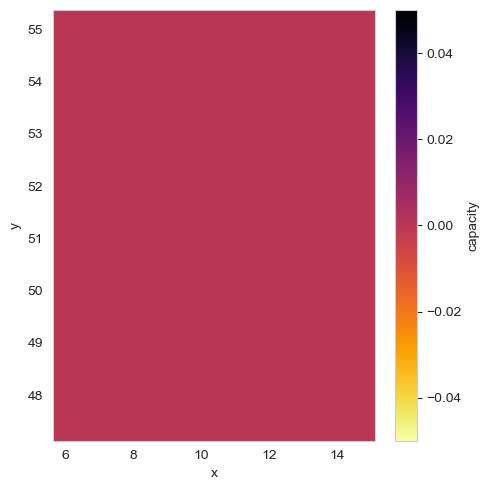

In [108]:
solar_layout.plot(cmap="inferno_r", size=5, aspect=1)
plt.title = ("Installed PV in Germany until 2012")
plt.tight_layout()
plt.show()


In [123]:
PV = cutout.pv(panel="CSi", orientation={"slope":30.0, "azimuth": 180.0}, layout=solar_layout)


In [114]:
# Converting xArray to dataframe with pandas
dataframe = PV.to_dataframe()
pd.set_option('display.max_rows', 5)
dataframe

,,specific generation
time,dim_0,
2012-01-01 00:00:00,0,0.0
2012-01-01 01:00:00,0,0.0
...,...,...
2012-02-29 22:00:00,0,0.0
2012-02-29 23:00:00,0,0.0


In [126]:
PV
PV.squeeze().to_series()

time
2012-01-01 00:00:00    0.0
2012-01-01 01:00:00    0.0
                      ... 
2012-02-29 22:00:00    0.0
2012-02-29 23:00:00    0.0
Name: specific generation, Length: 1440, dtype: float64

In [128]:
compare = (pd.DataFrame(dict(atlite=PV.squeeze().to_series(), opsd = opsd["DE_solar_generation_actual"]))/1e3)
compare

,atlite,opsd
2011-12-31 23:00:00,NaN,NaN
2012-01-01 00:00:00,0.0,NaN
...,...,...
2012-12-31 22:00:00,NaN,0.0
2012-12-31 23:00:00,NaN,0.0


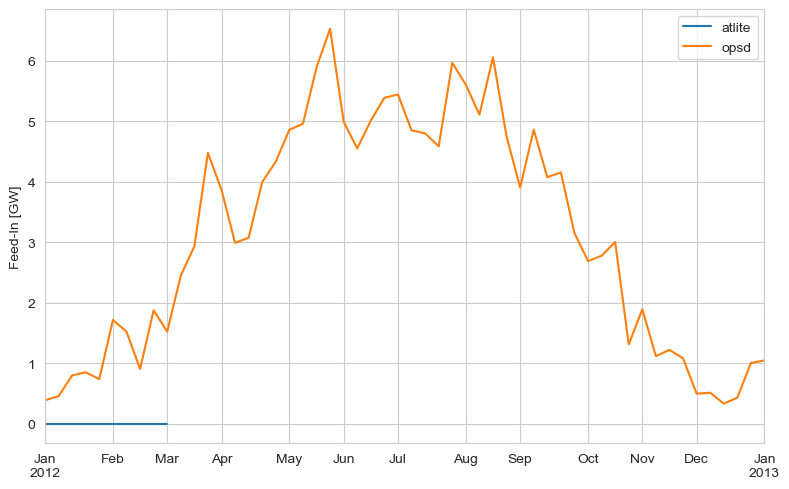

c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mappin

In [131]:
compare.resample("1W").mean().plot(figsize=(8, 5))
plt.ylabel("Feed-In [GW]")
#plt.title("PV time-series Germany 2012")
plt.tight_layout()

In [ ]:
# process for wind feed-ins
for t in atlite.windturbines:
    print(f"* {t}")

* Bonus_B1000_1000kW
* Enercon_E101_3000kW
* Enercon_E126_7500kW
* Enercon_E82_3000kW
* NREL_ReferenceTurbine_2016CACost_10MW_offshore
* NREL_ReferenceTurbine_2016CACost_6MW_offshore
* NREL_ReferenceTurbine_2016CACost_8MW_offshore
* NREL_ReferenceTurbine_2019ORCost_12MW_offshore
* NREL_ReferenceTurbine_2019ORCost_15MW_offshore
* NREL_ReferenceTurbine_2020ATB_12MW_offshore
* NREL_ReferenceTurbine_2020ATB_15MW_offshore
* NREL_ReferenceTurbine_2020ATB_18MW_offshore
* NREL_ReferenceTurbine_2020ATB_4MW
* NREL_ReferenceTurbine_2020ATB_5.5MW
* NREL_ReferenceTurbine_2020ATB_7MW
* NREL_ReferenceTurbine_5MW_offshore
* Siemens_SWT_107_3600kW
* Siemens_SWT_2300kW
* Suzlon_S82_1.5_MW
* Vestas_V112_3MW
* Vestas_V112_3MW_offshore
* Vestas_V164_7MW_offshore
* Vestas_V25_200kW
* Vestas_V47_660kW
* Vestas_V66_1750kW
* Vestas_V80_2MW_gridstreamer
* Vestas_V90_3MW


c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [136]:
turbine_categories = [
    dict(name="Vestas_V25_200kW", up=400.0),
    dict(name="Vestas_V47_660kW", up=700.0),
    dict(name="Bonus_B1000_1000kW", up=1100.0),
    dict(name="Suzlon_S82_1.5_MW", up=1600.0),
    dict(name="Vestas_V66_1750kW", up=1900.0),
    dict(name="Vestas_V80_2MW_gridstreamer", up=2200.0),
    dict(name="Siemens_SWT_2300kW", up=2500.0),
    dict(name="Vestas_V90_3MW", up=50000.0),
]

In [ ]:
low=0
for index, turbine_cat in enumerate(turbine_categories):
    capacities = load_capacities(
        "WindKraft", cap_range=[low, turbine_cat["up"]], until="2012"
    )
    layout = cutout.layout_from_capacity_list(capacities, "capacity")

    turbine_categories[index]["layout"]=layout
    low = turbine_cat["up"]

In [141]:
print(turbine_categories)

[{'name': 'Vestas_V25_200kW', 'up': 400.0, 'layout': <xarray.DataArray 'capacity' (y: 33, x: 38)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y        (y) float64 47.25 47.5 47.75 48.0 48.25 ... 54.5 54.75 55.0 55.25
  * x        (x) float64 5.75 6.0 6.25 6.5 6.75 ... 14.0 14.25 14.5 14.75 15.0}, {'name': 'Vestas_V47_660kW', 'up': 700.0, 'layout': <xarray.DataArray 'capacity' (y: 33, x: 38)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y        (y) float64 47.25 47.5 47.75 48.0 48.25 ... 54.5 54.75 55.0 55.25
  * x        (x) float64 5.75 6.0 6.25 6.5 6.75 ... 14.0 1

In [ ]:
wind = xr.Dataset()
for turbine_cat in turbine_categories:
    name = f"<{turbine_cat['up']} kw"
    wind[name] = cutout.wind(
        turbine=turbine_cat["name"],
        layout=turbine_cat["layout"],
        show_progress=False,
        add_cutout_windspeed=True,
    )
wind["total"] = sum(wind[c] for c in wind) 

c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mappin

In [ ]:
compare = pd.DataFrame(
    {
        "atlite": wind ["total"].squeeze().to_series(),
        "< 1600 kW": wind["< 1600.0 kW"].squeeze().to_series(),
        "opsd": opsd["DE_wind_generation_actual"],       
    }
)


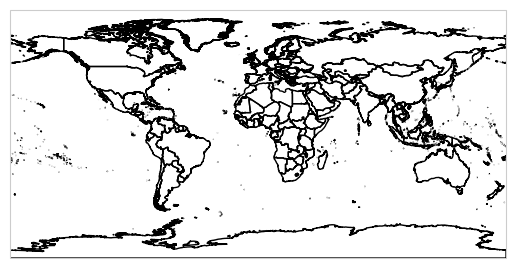

In [52]:
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create the shapereader Reader object as per your code
shp = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
)

# Set up a cartopy GeoAxes object with a specified map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Loop through the geometries in the shapefile and add them to the axes
for country in shp.records():
    geom = country.geometry
    ax.add_geometries([geom], ccrs.PlateCarree(), edgecolor='black', facecolor='none')

# Display the plot
plt.show()


In [56]:
iso_a2_codes = [record.attributes["ISO_A2"] for record in shp.records()]
print(set(iso_a2_codes))
if "NO" in iso_a2_codes:
    print("The ISO_A2 code for Norway ('NO') is in the dataset.")
else:
    print("The ISO_A2 code for Norway ('NO') is NOT in the dataset.")

{'UG', 'IS', 'IE', 'GR', 'AT', 'GT', 'BM', 'LB', 'MW', 'IN', 'TO', 'AI', 'HT', 'OM', 'AO', 'NI', 'AX', 'KM', 'BI', 'SL', 'SM', 'CW', 'CN-TW', 'CV', 'FM', 'EH', 'MA', 'TN', 'GG', 'TF', 'GH', 'WS', 'MN', 'PG', 'AZ', 'GY', 'KE', 'AR', 'PA', 'EG', 'BE', 'ER', 'DE', 'PK', 'SI', 'IM', 'NR', 'MK', 'MH', 'HM', 'RS', 'NC', 'AG', 'DJ', 'VN', 'NZ', 'BL', 'HN', 'MZ', 'VG', 'CI', 'CM', 'VC', 'GL', 'DZ', 'AL', 'ZA', 'PF', 'GD', 'SG', 'PR', 'BB', 'AD', 'AF', 'PH', 'LA', 'CN', 'WF', 'LI', 'ML', 'CG', 'UZ', 'BR', 'KH', 'AW', 'ST', 'GQ', 'BJ', 'SZ', 'MS', 'JE', 'BD', 'GB', 'NG', 'BY', 'PT', 'CD', 'NU', 'NE', 'AM', 'HK', 'LV', 'LS', 'MX', 'FJ', 'CF', 'HR', 'SK', 'FI', 'KW', 'MU', 'JO', 'BT', 'GN', 'TV', 'SA', 'PY', 'GS', 'QA', 'TD', 'BG', 'SS', 'MR', 'CU', 'IO', 'CL', 'KZ', 'CY', 'SB', 'LR', 'TL', 'MC', 'PW', 'CO', 'SY', 'SE', 'MG', 'PS', 'AS', 'AE', 'DO', 'SV', 'GE', 'CK', 'ET', 'VU', 'MO', 'UA', 'LY', 'RU', 'KP', 'CR', 'SX', 'YE', 'BN', 'SH', '-99', 'GA', 'TZ', 'ID', 'IQ', 'BO', 'BW', 'MM', 'AQ', 'FK',